In [43]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd
import matplotlib.pyplot as plt
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline

In [44]:
# download data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(train_data.columns[:12])
print(train_data.loc[:,train_data.columns[:12]])
# train_data.describe()
test_data.describe()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21         

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [45]:
# 分析数据
# label = raw_data['Survived']
# print(raw_data)
train_data.info()
data = train_data['Fare'].fillna(train_data['Fare'].median())
# print(raw_data['Fare'])
print(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
0        7.2500
1       71.2833
2        7.9250
3       53.1000
4        8.0500
5        8.4583
6       51.8625
7       21.0750
8       11.1333
9       30.0708
10      16.7000
11      26.5500
12       8.0500
13      31.2750
14       7.8542
15      16.0000
16      29.1250
17      13.0000
18      18.0000
19       7.2250
20      26.0000
21      13.0000
22       8.0292
23      35.5000
24      21.0750
25      31.3875

In [46]:
# Pclass => 乘客等级(1/2/3等舱位)
print (train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

print (train_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
# 将sibsp,parch合并成一个特征，主要是看是否是一个人
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1 
print (train_data[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())
train_data['IsAlone'] = 0
train_data.loc[train_data['FamilySize'] == 1, 'IsAlone'] = 1
print (train_data[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())
# 终点站这个特征有C，Q，S三个值，这个特征有缺失值，将其填充为S。同样需要进行映射为0,1,2。
train_data['Embarked'] = train_data['Embarked'].fillna('S')
print (train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())
# 船票票价这个特征是一个连续型数据，我们对其进行处理平分为四等分，后面分别映射为0，1，2，3。
# raw_data['Fare'] = raw_data['Fare'].fillna(raw_data['Fare'].median())
train_data['CategoricalFare'] = pd.qcut(train_data['Fare'], 4)
print (train_data[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())
# 年龄这个特征同样也是连续型数据，而且缺失值比较多，我们可以将缺失值当做一个类别进行处理，其他的年龄可以等分为五种类别，在后续的数据清理中处理，这里就总共有六种类别
age_null_count = train_data['Age'].isnull().sum()
averge_age = train_data['Age'].sum() / (891-age_null_count)
# 将为空的年龄填成平均年龄
train_data['Age'] = train_data['Age'].fillna(averge_age)
# print(raw_data['Age'])
# print(age_not_null_sum / (891-age_null_count))
# print(raw_data['Survived'][raw_data['Age'].isnull()])
train_data['CategoricalAge'] = pd.cut(train_data['Age'], 5)
print (train_data[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
      Sex  Survived
0  female  0.742038
1    male  0.188908
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
   IsAlone  Survived
0        0  0.505650
1        1  0.303538
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081
     CategoricalAge  Survived
0    (0.34, 16.336]  0.550000
1  (16.336, 32.252]  0.344168
2  (32.252, 48.168]  0.404255
3  (48.168, 64.084]  0.434783
4    (64.084, 80.0]  0.090909


In [47]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [48]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch']
# train_data = train_data.drop(drop_elements, axis = 1)
# train_data = train_data.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
# test  = test.drop(drop_elements, axis = 1)
print(train_data)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25          

In [49]:
# 处理数据
all_data = [train_data, test_data]

# print(train_data)
# train_data.info()


for dataset in all_data:
#     性别映射为0，1
    dataset['Sex'] = dataset['Sex'].replace(['male', 'female'],[0, 1])
    
    # 将SibSp和Parch两个合并为一个特征，家庭大小，并同时扩展为是否独自一人的特征
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
#     终点站，缺失值补充为S，有三种类型 
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # 票价，0，1，2，3四种
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # 年龄，缺失值为类别5
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4
    dataset.loc[ dataset['Age'].isnull(), 'Age']                       = 5
    dataset['Age'] = dataset['Age'].astype(int)
    
    #replace missing value with U0
    dataset['Cabin'] = dataset.Cabin.fillna('U0') # dataset.Cabin[dataset.Cabin.isnull()]='U0'


In [50]:
train_data.info()
test_data.info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Name               891 non-null object
Sex                891 non-null int64
Age                891 non-null int64
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null int64
Cabin              891 non-null object
Embarked           891 non-null int64
FamilySize         891 non-null int64
IsAlone            891 non-null int64
CategoricalFare    891 non-null category
CategoricalAge     891 non-null category
dtypes: category(2), int64(11), object(3)
memory usage: 99.4+ KB


<bound method DataFrame.info of      PassengerId  Pclass                                               Name  \
0            892       3                                   Kelly, Mr. James   
1            893       3                   Wilkes, Mrs. James (Ellen Needs)   
2            894       2                          Myles, Mr. Thomas Francis   
3            895       3                                   Wirz, Mr. Albert   
4            896       3       Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
5            897       3                         Svensson, Mr. Johan Cervin   
6            898       3                               Connolly, Miss. Kate   
7            899       2                       Caldwell, Mr. Albert Francis   
8            900       3          Abrahim, Mrs. Joseph (Sophie Halaut Easu)   
9            901       3                            Davies, Mr. John Samuel   
10           902       3                                   Ilieff, Mr. Ylio   
11           903    

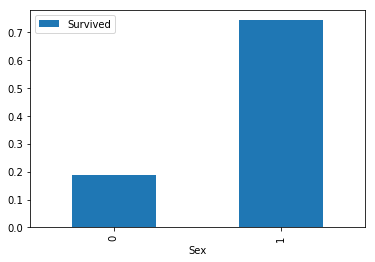

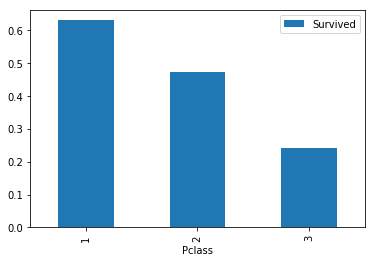

In [51]:
# 画图
# train_data.groupby(['Sex','Survived'])['Survived'].count()
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()
# train_data.groupby(['Pclass','Survived'])['Pclass'].count()
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

# bins = [0, 12, 18, 65, 100]
# train_data['Age_group'] = pd.cut(train_data['Age'], bins)
# train_data.groupby('Age_group')['Survived'].mean().plot(kind = 'bar')


In [52]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector 
    n_y -- scalar, number of classes 
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### 
    X = tf.placeholder(shape=[n_x, None], dtype=tf.float32)
    Y = tf.placeholder(shape=[n_y, None], dtype=tf.float32)
    ### END CODE HERE ###
    
    return X, Y

In [54]:
print(train_data.shape)
train_label = train_data['Survived']
print(train_label)

(891, 16)
0      0
1      1
2      1
3      1
4      0
5      0
6      0
7      0
8      1
9      1
10     1
11     1
12     0
13     0
14     0
15     1
16     0
17     1
18     0
19     1
20     0
21     1
22     1
23     1
24     0
25     1
26     0
27     0
28     1
29     0
      ..
861    0
862    1
863    0
864    0
865    1
866    1
867    0
868    0
869    1
870    0
871    1
872    0
873    0
874    1
875    1
876    0
877    0
878    0
879    1
880    1
881    0
882    0
883    0
884    0
885    0
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


In [55]:
X, Y = create_placeholders(12288, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(6, ?), dtype=float32)


In [56]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. 
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.Variable(tf.random_normal([20, 8]), name='W1')
    b1 = tf.Variable(tf.random_normal([20, 1]), name='b1')

    W2 = tf.Variable(tf.random_normal([10, 20]), name='W2')
    b2 = tf.Variable(tf.random_normal([10, 1]), name='b2')

    W3 = tf.Variable(tf.random_normal([1, 10]), name='W3')
    b3 = tf.Variable(tf.random_normal([1, 1]), name='b3')
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [57]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                                            # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                                              # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [58]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    ### END CODE HERE ###
    
    return cost

In [62]:
def model(X_train, Y_train, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []       # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X = tf.placeholder(dtype = np.float32, shape = [None, 8])
    Y = tf.placeholder(dtype = np.float32, shape = [None, 1])    
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            print(minibatch_size)
            print(m)
            print(m / minibatch_size)
        
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            
            
            
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        print('Total time: {0} seconds'.format(time.time() - start_time))
        print('Optimization Finished!')
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: train_set.T, Y: train_label.T}))
        print ("-------------Done----------------------")


        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        
        return parameters

In [64]:
parameters = model(train_data, train_label)


ValueError: Dimension 0 in both shapes must be equal, but are 8 and 1. Shapes are [8,1] and [1,?]. for 'softmax_cross_entropy_with_logits_1' (op: 'SoftmaxCrossEntropyWithLogits') with input shapes: [8,1], [1,?].